In [29]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

path = untar_data(URLs.CAMVID)
path.ls()

[WindowsPath('D:/Users/Lenovo/.fastai/data/camvid/codes.txt'),
 WindowsPath('D:/Users/Lenovo/.fastai/data/camvid/images'),
 WindowsPath('D:/Users/Lenovo/.fastai/data/camvid/labels'),
 WindowsPath('D:/Users/Lenovo/.fastai/data/camvid/valid.txt')]

In [30]:
path_lbl = path/'labels'
path_img = path/'images'

### subset classes

### data

In [31]:
fnames = get_image_files(path_img)
fnames[:3]

[WindowsPath('D:/Users/Lenovo/.fastai/data/camvid/images/0001TP_006690.png'),
 WindowsPath('D:/Users/Lenovo/.fastai/data/camvid/images/0001TP_006720.png'),
 WindowsPath('D:/Users/Lenovo/.fastai/data/camvid/images/0001TP_006750.png')]

In [32]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[WindowsPath('D:/Users/Lenovo/.fastai/data/camvid/labels/0001TP_006690_P.png'),
 WindowsPath('D:/Users/Lenovo/.fastai/data/camvid/labels/0001TP_006720_P.png'),
 WindowsPath('D:/Users/Lenovo/.fastai/data/camvid/labels/0001TP_006750_P.png')]

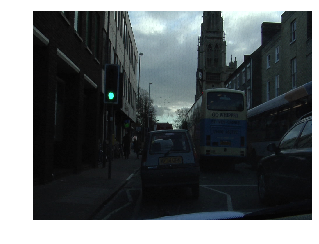

In [33]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

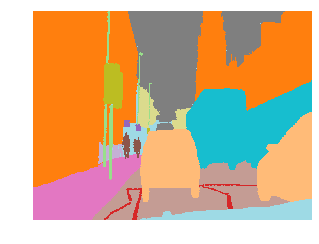

In [34]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [35]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30],
          [19, 19, 19,  ..., 30, 30, 30]]]))

In [36]:
codes = np.loadtxt(path/'codes.txt', dtype=str);codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

### datasets

In [37]:
size = src_size // 2 # integer divide. use '//' (not '/') to get result type of int

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the avaliable GPU RAM
if free > 8200:
    bs = 8
else:
    bs = 4
print(f'using bs={bs}, have {free}MB of GPU RAM free')

using bs=4, have 5562MB of GPU RAM free


In [38]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [39]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

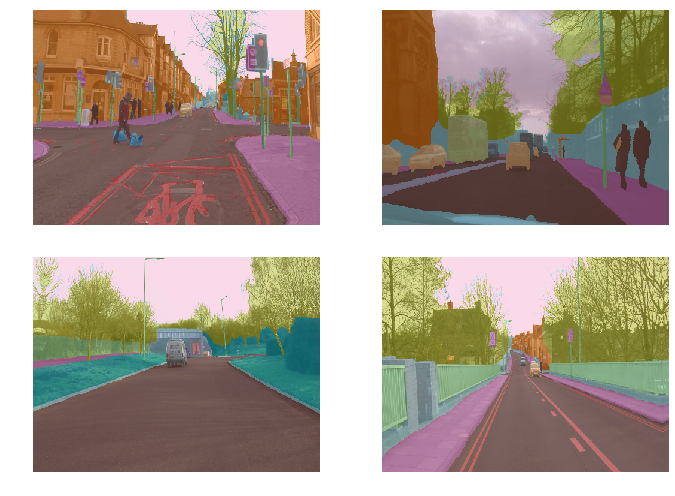

In [40]:
data.show_batch(2, figsize=(10, 7)) # 随机show一个batch, 数量取决于batch size

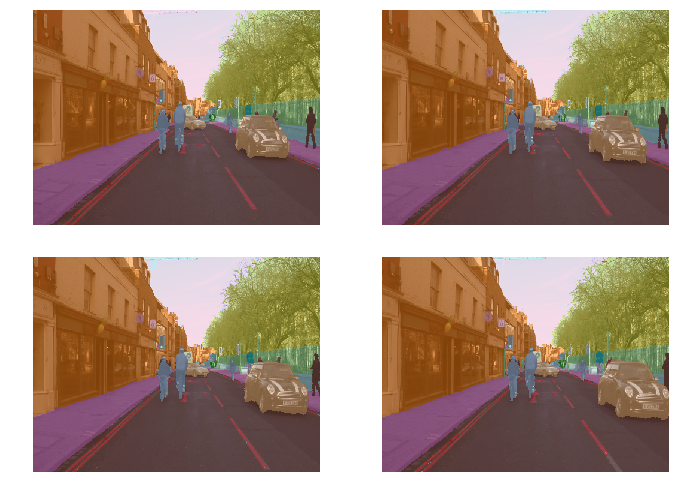

In [41]:
data.show_batch(2, figsize=(10, 7), ds_type=DatasetType.Valid) # ds_type指定是看训练集还是验证集还是测试集，默认为为训练集

model

In [42]:
name2id = {v:k for k, v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

metrics = acc_camvid

wd = 1e-2
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd).to_fp16() # mixed precision training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


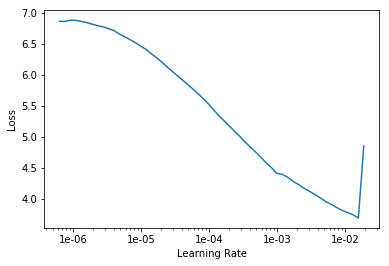

In [43]:
lr_find(learn)
learn.recorder.plot()

In [44]:
lr = 3e-3
learn.fit_one_cycle(10, slice(lr), pct_start=0.9) # fit_one_cycle使用的是变化的学习率

epoch,train_loss,valid_loss,acc_camvid,time
0,1.006491,0.770592,0.819717,02:31
1,0.703214,0.535385,0.854054,02:25
2,0.682910,0.620461,0.830669,02:26
3,0.678215,0.671563,0.818107,02:24
4,0.608968,0.495099,0.869267,02:27
5,0.601052,0.436469,0.876657,02:25
6,0.548854,0.458470,0.879302,02:28
7,0.544982,0.418537,0.877345,02:27
8,0.513763,0.452941,0.876034,02:24
9,0.402250,0.335177,0.895576,02:24


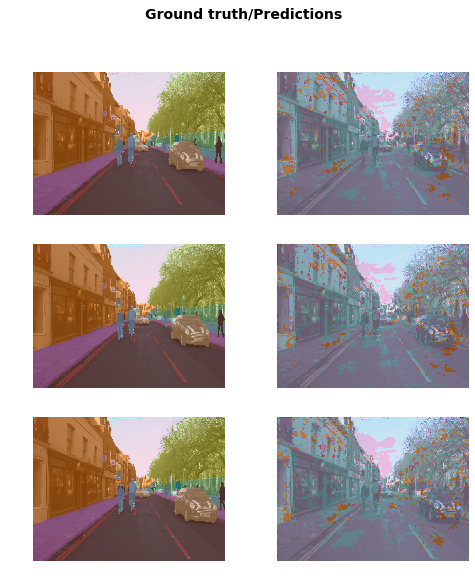

In [43]:
learn.save('stage-1')
learn.load('stage-1')
learn.show_results(rows=3, figsize=(8,9)) # show up to 4 rows, but why does the output always look the same ?

In [71]:
learn.unfreeze()
lrs = slice(lr/400, lr/4)
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.372865,0.316755,0.900915,02:32
1,0.357882,0.305126,0.905041,02:35
2,0.366625,0.310616,0.903528,02:33
3,0.344791,0.306143,0.905858,02:31
4,0.352503,0.297576,0.913288,02:32
5,0.339142,0.313802,0.903288,02:30
6,0.332102,0.272280,0.923071,02:29
7,0.344094,0.323310,0.913489,02:33
8,0.318631,0.285908,0.921609,02:32
9,0.320082,0.302925,0.914881,02:30


In [72]:
learn.save('stage-2')

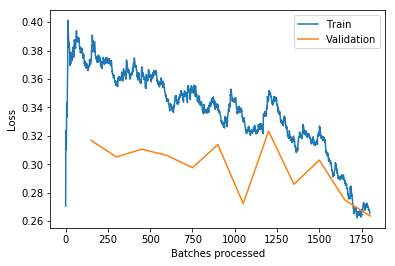

In [73]:
learn.recorder.plot_losses() # a little overfitting ?

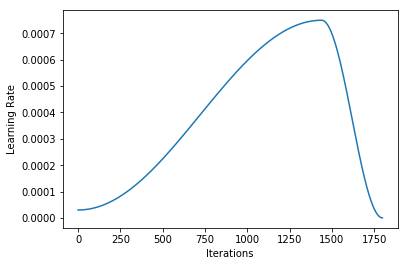

In [74]:
learn.recorder.plot_lr()

### go big

In [44]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
if free > 8200:
    bs = 3
else:
    bs = 1
print(f'using bs = {bs}, have {free} MB of GPU RAM free')

this Learner object self-destroyed - it still exists, but no longer usable
using bs = 1, have 7170 MB of GPU RAM free


In [45]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
       .databunch(bs=bs)
       .normalize(imagenet_stats))

learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: D:\Users\Lenovo\.fastai\data\camvid\images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: D:\Users\Lenovo\.fastai\data\camvid\images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


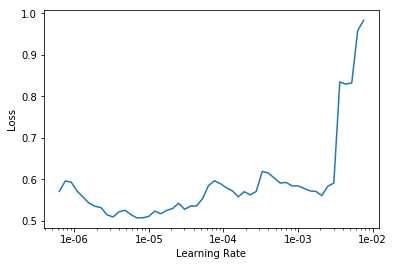

In [15]:
lr_find(learn)
learn.recorder.plot()

In [16]:
lr = 1e-3
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.437071,0.345307,0.906392,06:07
1,0.356906,0.338481,0.908216,06:06
2,0.370614,0.330794,0.907596,06:06
3,0.396095,0.302789,0.922140,06:07
4,0.371675,0.403186,0.907462,06:05
5,0.323346,0.308114,0.914625,06:03
6,0.368549,0.311704,0.911656,06:00
7,0.398336,0.410051,0.903272,06:02
8,0.315333,0.310159,0.917390,06:02
9,0.240750,0.284537,0.926801,06:01


In [17]:
learn.save('stage-1-big')

In [18]:
learn.load('stage-1-big')
learn.unfreeze()
lrs = slice(1e-6, lr/10)
learn.fit_one_cycle(10, lrs) # 传入的是最大lr,训练过程中lr是动态变化的

epoch,train_loss,valid_loss,acc_camvid,time
0,0.216025,0.284576,0.926594,06:33
1,0.214504,0.277098,0.926349,06:22
2,0.239475,0.256508,0.931373,06:21
3,0.233140,0.287299,0.922587,06:21
4,0.215654,0.270349,0.929988,06:21
5,0.195435,0.268719,0.930115,06:20
6,0.182545,0.277469,0.927056,06:20
7,0.190872,0.271336,0.930237,06:20
8,0.185873,0.268931,0.930773,06:22
9,0.193045,0.268922,0.930390,06:28


In [20]:
learn.save('stage-2-big')

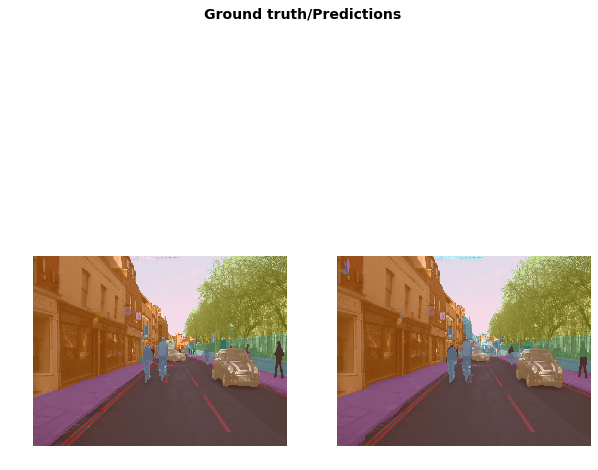

In [46]:
learn.load('stage-2-big')
learn.show_results(rows=3, figsize=(10, 10))

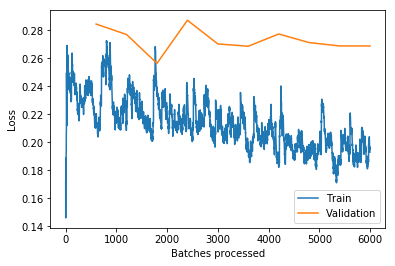

In [24]:
learn.recorder.plot_losses() # overfitting ?!